In [68]:
#Load Python libraries
from sklearn import metrics, ensemble
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, train_test_split, cross_validate
import xgboost as xgb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [69]:
#Data preparation
data_dir = "../kkbox_data/"

df = pd.read_csv('../kkbox_data/train.csv')

# 1% sample of items
df = df.sample(frac=0.01)

In [70]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
5229938,1Ik8ihgm4qVc1wBb+R267O96zNDdLJcgccjmtwkU2H4=,Le29tgmWG9EEyt+2fElCFT05/bzYusTqzAME5PaeUz8=,search,Local playlist more,online-playlist,1
4184977,2YlpGqcCEV6p0bfdloxbSB2oPfjHhwIwI/s/myptd20=,0Ge/KaQyOshftregia3O17tJVxCneIpU7tgfkWRXFOo=,my library,Local playlist more,local-playlist,1
125994,4ub3L4zSvwZqWFDuAbGaSZAnQ+oFvXbRjCllbC7mwzA=,oDa6FWM8MYb6bfrq134wyBy/YkODxg+m7AkVGplizZU=,discover,NaN,online-playlist,1
6333378,iQ33vEIDhUoO2pkhxmiXICzud+juItnyYfWOK4GZXzc=,LqfyqJ8vWRlV7S62TrJSxwqHGM1KJwAmq2W8ZyWr1f0=,radio,Radio,radio,1
4078805,oYj8sdndYHrNXFpZ1bANxT+phHx2/lfLOtDnUDDuVRs=,qq95pASsarhhJaUTP3/XIoDOr8XSUpB9Alw1GSd/sKg=,discover,Album more,album,1


In [71]:
# Load and join songs data
songs = pd.read_csv('../kkbox_Data/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and join songs data
members = pd.read_csv('../kkbox_data/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73774 entries, 0 to 73773
Data columns (total 18 columns):
msno                      73774 non-null object
song_id                   73774 non-null object
source_system_tab         73503 non-null object
source_screen_name        69647 non-null object
source_type               73532 non-null object
target                    73774 non-null int64
song_length               73770 non-null float64
genre_ids                 72582 non-null object
artist_name               73770 non-null object
composer                  57071 non-null object
lyricist                  41998 non-null object
language                  73769 non-null float64
city                      73774 non-null int64
bd                        73774 non-null int64
gender                    44223 non-null object
registered_via            73774 non-null int64
registration_init_time    73774 non-null int64
expiration_date           73774 non-null int64
dtypes: float64(2), int64(6), o

In [73]:
# Count Na in %
df.isnull().sum()/df.isnull().count()*100

msno                       0.000000
song_id                    0.000000
source_system_tab          0.367338
source_screen_name         5.594112
source_type                0.328029
target                     0.000000
song_length                0.005422
genre_ids                  1.615745
artist_name                0.005422
composer                  22.640768
lyricist                  43.072085
language                   0.006777
city                       0.000000
bd                         0.000000
gender                    40.056117
registered_via             0.000000
registration_init_time     0.000000
expiration_date            0.000000
dtype: float64

In [74]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [75]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [76]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,1Ik8ihgm4qVc1wBb+R267O96zNDdLJcgccjmtwkU2H4=,Le29tgmWG9EEyt+2fElCFT05/bzYusTqzAME5PaeUz8=,search,Local playlist more,online-playlist,1,260388.0,465,動力火車 (Power Station),unknown,...,male,3,2013-11-26,2018-08-06,2013,11,26,2018,8,6
1,2YlpGqcCEV6p0bfdloxbSB2oPfjHhwIwI/s/myptd20=,0Ge/KaQyOshftregia3O17tJVxCneIpU7tgfkWRXFOo=,my library,Local playlist more,local-playlist,1,209397.0,465,Avril Lavigne,unknown,...,female,7,2011-11-13,2017-09-26,2011,11,13,2017,9,26
2,4ub3L4zSvwZqWFDuAbGaSZAnQ+oFvXbRjCllbC7mwzA=,oDa6FWM8MYb6bfrq134wyBy/YkODxg+m7AkVGplizZU=,discover,unknown,online-playlist,1,237557.0,465,BIGBANG,TEDDY/CHOICE37/G-DRAGON,...,unknown,7,2015-09-08,2017-10-07,2015,9,8,2017,10,7
3,iQ33vEIDhUoO2pkhxmiXICzud+juItnyYfWOK4GZXzc=,LqfyqJ8vWRlV7S62TrJSxwqHGM1KJwAmq2W8ZyWr1f0=,radio,Radio,radio,1,230667.0,458,柯有倫 (Alan Kuo),柯有倫 / SKOT SUYAMA,...,male,7,2016-09-03,2017-10-03,2016,9,3,2017,10,3
4,oYj8sdndYHrNXFpZ1bANxT+phHx2/lfLOtDnUDDuVRs=,qq95pASsarhhJaUTP3/XIoDOr8XSUpB9Alw1GSd/sKg=,discover,Album more,album,1,203128.0,1609,Various Artists,B. Sandee| A. Palmer| E. McCarthy| J. de Jong|...,...,unknown,7,2016-08-22,2017-09-21,2016,8,22,2017,9,21


In [77]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')

In [78]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

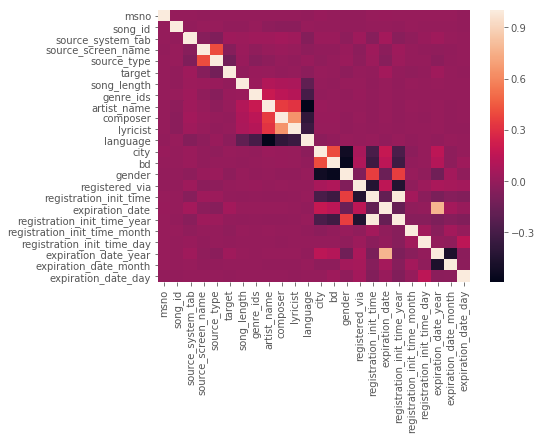

In [79]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

In [80]:
#Drop columns
df = df.drop(['expiration_date', 'lyricist'], 1)

In [81]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,930,10241,6,8,6,1,260388.0,135,5002,7724,...,43,1,3,2503,2013,11,26,2018,8,6
1,1298,1008,3,8,4,1,209397.0,135,396,7724,...,48,0,7,1874,2011,11,13,2017,9,26
2,1956,22517,0,19,6,1,237557.0,135,427,6717,...,0,2,7,3152,2015,9,8,2017,10,7
3,13595,10329,5,13,7,1,230667.0,132,5654,8837,...,29,1,7,3448,2016,9,3,2017,10,3
4,15395,23634,0,0,0,1,203128.0,44,4485,693,...,0,2,7,3436,2016,8,22,2017,9,21


In [61]:
#Random Forest
#I selected the most informative columns using Random Forest Model.

# Model with the best estimator
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

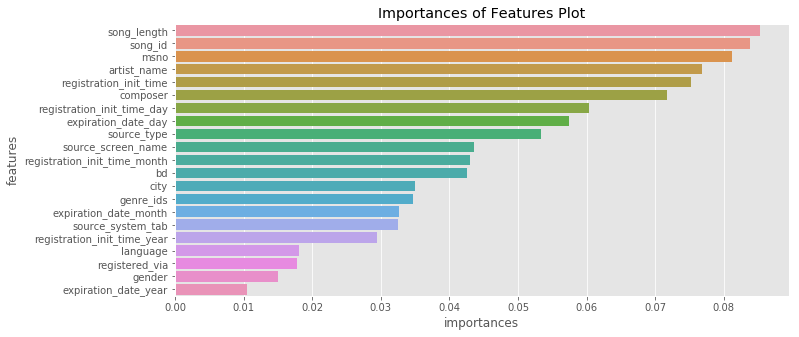

In [63]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

In [64]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)

In [82]:
df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'song_length', 'genre_ids', 'artist_name',
       'composer', 'language', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'registration_init_time_year',
       'registration_init_time_month', 'registration_init_time_day',
       'expiration_date_year', 'expiration_date_month', 'expiration_date_day'],
      dtype='object')

In [83]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
0,930,10241,6,8,6,1,260388.0,135,5002,7724,...,43,1,3,2503,2013,11,26,2018,8,6
1,1298,1008,3,8,4,1,209397.0,135,396,7724,...,48,0,7,1874,2011,11,13,2017,9,26
2,1956,22517,0,19,6,1,237557.0,135,427,6717,...,0,2,7,3152,2015,9,8,2017,10,7
3,13595,10329,5,13,7,1,230667.0,132,5654,8837,...,29,1,7,3448,2016,9,3,2017,10,3
4,15395,23634,0,0,0,1,203128.0,44,4485,693,...,0,2,7,3436,2016,8,22,2017,9,21


In [84]:
#XGBoost
# Train & Test split
target = df.pop('target')

In [85]:
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.3)

# Delete df
del df

In [86]:
train_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,language,...,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
48597,15064,19530,1,7,11,259599.0,210,4485,3833,52.0,...,0,2,7,3511,2016,11,5,2017,10,4
46138,13132,20293,3,8,3,278825.0,135,5063,8016,3.0,...,21,0,3,2469,2013,10,23,2017,7,18
43321,5301,8780,3,8,4,223561.0,135,4929,6023,24.0,...,51,1,7,1820,2011,9,19,2017,9,17
21941,2491,27276,3,8,3,873394.0,196,6290,7724,-1.0,...,0,2,7,3155,2015,9,11,2017,9,14
15582,16791,23394,3,8,4,186850.0,135,1866,7724,52.0,...,25,0,9,1841,2011,10,11,2017,10,8


In [87]:
train_labels.head()

48597    0
46138    0
43321    0
21941    1
15582    1
Name: target, dtype: int64

In [88]:
#The best estimator was selected by Randomized Grid Search with Stratified Shuffle Split Cross Validation.
# Create model

model = xgb.XGBClassifier()

# Create parameters grid

parameters_grid = { 'learning_rate' : [0.1, 0.2, 0.5], 'max_depth' : [5, 10, 15], 'n_estimators' : [150, 250, 300], 'min_child_weight' : [3, 5, 10] }

# Strategy of cross validation

cv = model_selection.StratifiedShuffleSplit(train_labels, test_size = 0.3, random_state=0)

# Create Grid search Strategy

grid_cv = model_selection.RandomizedSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

# Fit model by Grid
print(train_data.shape, train_labels.shape)
grid_cv.fit(train_data, train_labels)

# Model with the best estimator

grid_cv.bestestimator

(51641, 21) (51641,)


TypeError: 'Series' object cannot be interpreted as an integer

In [89]:
# Create model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=5, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [90]:
# Predicting
predict_labels = model.predict(test_data)

In [91]:
print(metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.61      0.60      0.61     10917
           1       0.62      0.64      0.63     11216

    accuracy                           0.62     22133
   macro avg       0.62      0.62      0.62     22133
weighted avg       0.62      0.62      0.62     22133



In [92]:
print(predict_labels.shape, test_labels.shape, test_data.shape)

(22133,) (22133,) (22133, 21)


In [93]:
test_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,language,...,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
26067,3294,9119,0,11,6,212750.0,57,199,253,52.0,...,0,2,7,2743,2014,7,25,2017,9,22
37717,15524,26876,0,19,10,265404.0,135,4897,7915,3.0,...,0,2,7,3517,2016,11,11,2017,9,10
14835,17230,27318,0,11,6,216600.0,214,4485,2779,31.0,...,21,1,9,610,2007,5,6,2017,10,7
27806,5360,19608,3,8,4,188186.0,135,6612,9957,3.0,...,0,2,7,2373,2013,7,19,2017,9,19
13891,13105,18297,6,1,10,254026.0,135,2197,7724,17.0,...,0,2,7,2717,2014,6,28,2017,9,24


In [94]:
train_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,language,...,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
48597,15064,19530,1,7,11,259599.0,210,4485,3833,52.0,...,0,2,7,3511,2016,11,5,2017,10,4
46138,13132,20293,3,8,3,278825.0,135,5063,8016,3.0,...,21,0,3,2469,2013,10,23,2017,7,18
43321,5301,8780,3,8,4,223561.0,135,4929,6023,24.0,...,51,1,7,1820,2011,9,19,2017,9,17
21941,2491,27276,3,8,3,873394.0,196,6290,7724,-1.0,...,0,2,7,3155,2015,9,11,2017,9,14
15582,16791,23394,3,8,4,186850.0,135,1866,7724,52.0,...,25,0,9,1841,2011,10,11,2017,10,8


In [119]:
test = pd.read_csv("../kkbox_data/test.csv", dtype={'msno' : 'category',
                                                'source_system_tab' : 'category',
                                                'source_screen_name' : 'category',
                                                'source_type' : 'category',
                                                'song_id' : 'category'})

In [122]:
songs = pd.read_csv(data_dir + 'songs.csv',dtype={'genre_ids': 'category',
                                                  'language' : 'category',
                                                  'artist_name' : 'category',
                                                  'composer' : 'category',
                                                  'lyricist' : 'category',
                                                  'song_id' : 'category'})
members = pd.read_csv(data_dir + 'members.csv',dtype={'city' : 'category',
                                                      'bd' : np.uint8,
                                                      'gender' : 'category',
                                                      'registered_via' : 'category'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv(data_dir + 'song_extra_info.csv')

In [120]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [123]:
test = test.merge(songs, on='song_id', how='left')

In [ ]:
members['membership_days'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)

def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1
    
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)
test = test.merge(members, on='msno', how='left')
test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')
test['genre_ids'].fillna('no_genre_id',inplace=True)
train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)

In [110]:
ids = df['id']

In [111]:
df = df.drop(['id'], axis=1)

In [112]:
df.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type'],
      dtype='object')

In [113]:
# Dates to categoty
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

In [114]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type
0,4776,20496,3,7,3
1,4776,36534,3,7,3
2,242,6313,0,-1,9
3,490,37628,5,12,7
4,490,14410,5,12,7


In [115]:
model.predict(df)

ValueError: feature_names mismatch: ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type', 'song_length', 'genre_ids', 'artist_name', 'composer', 'language', 'city', 'bd', 'gender', 'registered_via', 'registration_init_time', 'registration_init_time_year', 'registration_init_time_month', 'registration_init_time_day', 'expiration_date_year', 'expiration_date_month', 'expiration_date_day'] ['msno', 'song_id', 'source_system_tab', 'source_screen_name', 'source_type']
expected song_length, language, expiration_date_year, gender, genre_ids, registration_init_time, composer, bd, expiration_date_day, registration_init_time_day, city, artist_name, registration_init_time_year, expiration_date_month, registered_via, registration_init_time_month in input data

In [74]:
test_labels

39694    0
58995    0
39189    0
63588    1
37191    1
25104    0
7907     1
25563    1
66771    0
17564    1
35253    0
19256    0
27544    1
53988    0
32011    0
31841    0
63870    1
36907    0
66831    1
38618    1
37487    0
25331    0
24886    1
9743     0
19713    1
24061    1
56640    1
21866    0
33480    1
39522    1
        ..
1892     0
15483    0
40046    1
21151    0
13975    0
40182    0
37247    0
32045    0
67202    1
38720    0
18915    0
61352    1
68160    0
63038    0
36256    0
6846     0
51473    0
72396    0
53994    0
8124     0
32214    0
46695    0
9168     0
45924    0
52017    1
63234    1
52147    1
27667    0
41196    0
2048     0
Name: target, Length: 22133, dtype: int64

In [23]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# get some data
digits = load_digits()
X, y = digits.data, digits.target

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 2.96 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.932 (std: 0.022)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 9, 'min_samples_split': 9}

Model with rank: 2
Mean validation score: 0.929 (std: 0.017)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.924 (std: 0.032)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_split': 6}

GridSearchCV took 9.95 seconds for 72 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.933 (std: 0.032)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 3}

Model with rank: 2
Mean validation score: 0.931 (std: 0.023)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_fea

In [28]:
print(X)

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


In [ ]:
print ('Saving predictions Model model of gbdt')

subm = pd.DataFrame()
subm['id'] = ids
subm['target'] = p_test_avg
subm.to_csv(data_path + 'submission_lgbm_avg.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')